# Using EcoFOCIpy to apply a 35hr Lanzcos Filter to 2D data (xarray)

- input:
    - example uses erddap but other versions may use netcdf file
- output is currently only csv files for each depth (exported from a pandas dataframe (so you could just continue analysis)

TODO:
- output to xarray modified netcdf file

In [5]:
import xarray as xa
import pandas as pd
import numpy as np
from erddapy import ERDDAP

import EcoFOCIpy.math.lanzcos as lanzcos 
import EcoFOCIpy.plots.TimeSeriesStickPlot as TimeseriesStickPlot

In [6]:
dataset = 'ADCP_Mooring_15ckp1a_final'

dataset_id = dataset.split('_')[-2]

ecofoci_server_url='http://ecofoci-field.pmel.noaa.gov:8080/erddap'

e = ERDDAP(server=ecofoci_server_url,
           protocol="griddap",)

e.dataset_id = dataset

ds = e.to_xarray()

In [71]:
ds = ds.isel(time=slice(96,None))
ds

<xarray.Dataset>
Dimensions:        (time: 8565, depth: 7, latitude: 1, longitude: 1)
Coordinates:
  * time           (time) datetime64[ns] 2015-09-18T19:00:00 ... 2016-09-09T1...
  * depth          (depth) float64 4.0 8.0 12.0 16.0 20.0 24.0 28.0
  * latitude       (latitude) float32 70.84
  * longitude      (longitude) float64 196.9
Data variables:
    vcomp_current  (time, depth, latitude, longitude) float32 4.402 ... -0.5251
    ucomp_current  (time, depth, latitude, longitude) float32 -17.05 ... 7.066
    w_1204         (time, depth, latitude, longitude) float32 0.8 0.1 ... -0.1
    Werr_1201      (time, depth, latitude, longitude) float32 -7.7 -3.0 ... -0.1
Attributes: (12/37)
    cdm_data_type:                 Grid
    COMPOSITE:                     1
    Conventions:                   COARDS, CF-1.6, ACDD-1.3
    CREATION_DATE:                 June 05, 2020 16:17 UTC
    creation_date:                 April 16, 2020 21:06 UTC
    DATA_CMNT:                     3060.VEL
    ...                            ...
    time_coverage_end:             2016-09-09T15:00:00Z
    time_coverage_start:           2015-09-14T19:00:00Z
    title:                         QC'd (final) ADCP Vel Data from 15CKP-1A
    WATER_DEPTH:                   42.0
    WATER_MASS:                    B
    Westernmost_Easting:           196.8946533203125

/var/folders/vv/blq095kj0xj9nz1v0ffdwfch0000gp/T/ipykernel_3335/134806340.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['ufdata'][missing_index_u] = np.nan
/var/folders/vv/blq095kj0xj9nz1v0ffdwfch0000gp/T/ipykernel_3335/134806340.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['vfdata'][missing_index_v] = np.nan
/Users/bell/Programs/EcoFOCIpy/src/EcoFOCIpy/plots/TimeSeriesStickPlot.py:120: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(ax2.get_xticklabels(), visible=True)
/var/folders/vv/blq095kj0xj9nz1v0ffdwfch0000gp/T/ipykernel_3335/134806340.py:

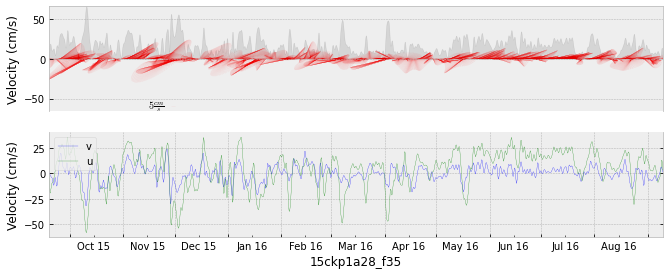

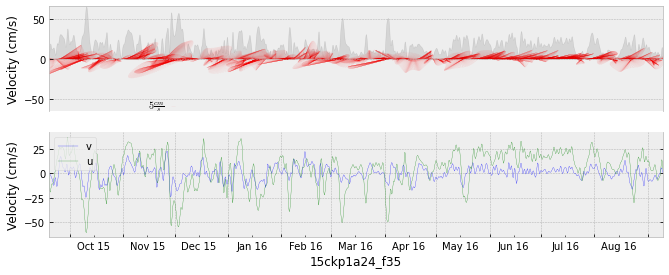

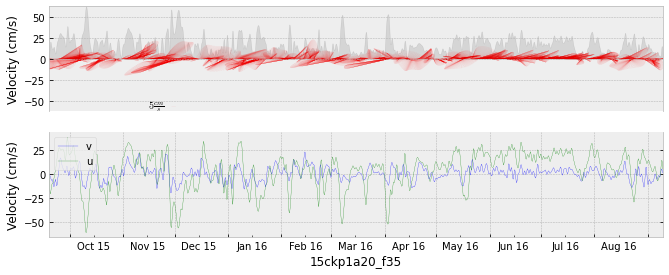

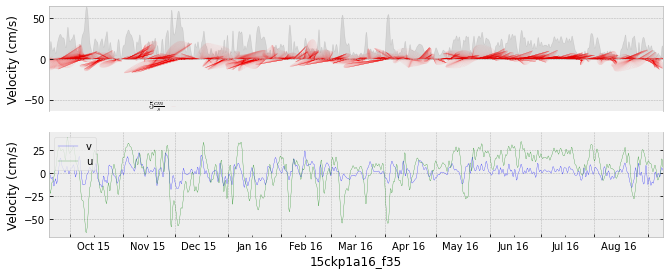

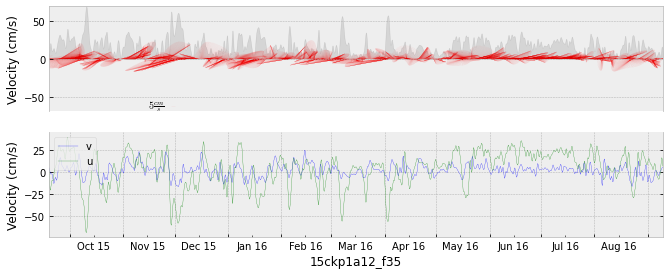

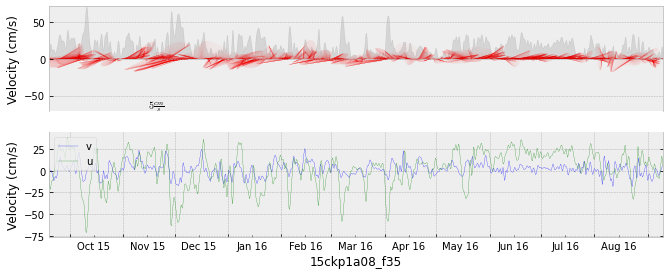

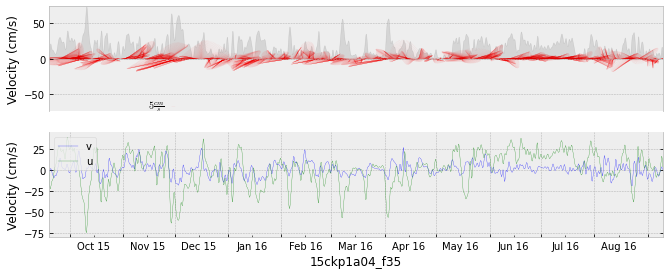

In [73]:
plotfigs = True
verbose = False
savedata = True
domath = False

for dd in range(ds.depth.size-1,-1,-1):
    udata, vdata = None,None
    depth_curr = ds.isel(depth=dd)
    if verbose:
        print(f'depth: {depth_curr}, {dd}')
    ### filter
    try:
        udata = depth_curr.u_curr_comp[0,0,:].to_pandas()
        vdata = depth_curr.v_curr_comp[0,0,:].to_pandas()
    except:
        udata = depth_curr.ucomp_current[:,0,0].to_pandas()
        vdata = depth_curr.vcomp_current[:,0,0].to_pandas()
        
    data = pd.concat([udata, vdata], axis=1)
    data.columns = ['udata','vdata']

    data['udata'][data.udata > 1e34]=np.nan
    data['vdata'][data.vdata > 1e34]=np.nan
    data = data.resample('1H').mean()

    ## missing data fill limited by number of hours to linearly interpolate
    data['tempu'] = data['udata'].interpolate(method='time',limit=6)
    data['tempv'] = data['vdata'].interpolate(method='time',limit=6)

    # get index of missing data that wasn't filled
    # the remaining missing data will continue to be missing after analysis
    # this data and the edges of the timeseries need to have the effects of the filter window accounted for

    missing_index_u = np.isnan(data.tempu)
    missing_index_v = np.isnan(data.tempv)
    data['tempu'] = data['udata'].interpolate(method='time')
    data['tempv'] = data['vdata'].interpolate(method='time')

    #filter data with rudimentary matlab script
    data['ufdata'] = lanzcos.lanzcos(data.tempu.values,1,35)+data['udata'].mean()
    data['vfdata'] = lanzcos.lanzcos(data.tempv.values,1,35)+data['vdata'].mean()
    data['ufdata'][missing_index_u] = np.nan
    data['vfdata'][missing_index_v] = np.nan    

    #extra calculations
    if domath:
        print(dataset_id)
        print(data.describe()[['ufdata','vfdata']])

    #plot
    if plotfigs:
        try:
            p1 = TimeseriesStickPlot.Timeseries1dStickPlot()
            plt1, fig1 = p1.plot(timedata=data.index, 
                                 udata=data.ufdata.values, 
                                 vdata=data.vfdata.values,
                                 rotate=0)
            plt1.xlabel(dataset_id+str(int(ds.depth[dd].values)).zfill(2)+'_f35')
            fig1.savefig(dataset_id+str(int(ds.depth[dd].values)).zfill(2)+'_f35'+'.png',dpi=600)

            if verbose:
                #subsample
                datasub=data.resample('D').median()
                p1 = TimeseriesStickPlot.Timeseries1dStickPlot()
                plt1, fig1 = p1.plot(timedata=datasub.index, 
                                     udata=datasub.ufdata.values, 
                                     vdata=datasub.vfdata.values,
                                     linescale=10,
                                     rotate=0)
                plt1.xlabel(dataset_id+str(int(ds.depth[dd].values)).zfill(2)+'_f35_daily')
                fig1.savefig(dataset_id+str(int(ds.depth[dd].values)).zfill(2)+'_f35_daily'+'.png',dpi=600)

                p1 = TimeseriesStickPlot.Timeseries1dStickPlot()
                plt1, fig1 = p1.plot(timedata=data.index, 
                                     udata=data.udata.values, 
                                     vdata=data.vdata.values,
                                     rotate=0)
                plt1.xlabel(dataset_id+str(int(ds.depth[dd].values)).zfill(2)+'_nofilter')
                fig1.savefig(dataset_id+str(int(ds.depth[dd].values)).zfill(2)+'_nofilter'+'.png',dpi=600)
        except:
            pass
    #save data
    if savedata:
        data[['ufdata','vfdata']].to_csv(dataset_id+'_'+str(int(ds.depth[dd].values)).zfill(2)+'_f35'+'.csv')